In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict

## Define Classes

In [2]:
class TwoStepEnvironment:
    def __init__(self):
        self.n_states = 7
        
        # First stage transitions (state 0 -> states 1 or 2)
        self.transitions = {
            0: {  # from state 0
                0: {1: 0.7, 2: 0.3},  # action 0
                1: {1: 0.3, 2: 0.7}   # action 1
            }
        }
        
        # Second stage deterministic transitions
        self.deterministic = {
            1: {0: 3, 1: 4},  # from state 1 to states 3 or 4
            2: {0: 5, 1: 6}   # from state 2 to states 5 or 6
        }
        
        # Terminal states are 3, 4, 5, 6
        self.reward_probs = {
            3: 0.7,
            4: 0.3,
            5: 0.3,
            6: 0.7
        }
        
        self.reset()

    def step(self, action):
        if self.current_state in [3, 4, 5, 6]:  # Terminal states
            return self.current_state, 0, True
            
        if self.current_state == 0:  # First stage
            probs = self.transitions[0][action]
            next_state = np.random.choice(list(probs.keys()), p=list(probs.values()))
            self.is_common = probs[next_state] == 0.7
        else:  # Second stage
            next_state = self.deterministic[self.current_state][action]
            
        reward = 0
        if next_state in self.reward_probs:
            reward = 1 if np.random.random() < self.reward_probs[next_state] else 0
            
        self.last_reward = reward
        self.current_state = next_state
        done = next_state in [3, 4, 5, 6]
        
        return next_state, reward, done
    
    def reset(self):
        self.current_state = 0
        self.is_common = None
        self.last_reward = None
        return self.current_state

In [14]:
class SRAgent:
    def __init__(self, alpha1=0.25, alpha2=0.05, temperature=0.3, gamma=0.95, lambda_param=0.9, imp_samp=True):
        # SR matrix is 8x8
        # Index 0: state 0, action 0
        # Index 1: state 0, action 1
        # Index 2-7: states 1-6
        self.SR = np.eye(8)
        self.reward_vector = np.zeros(8)
        
        self.alpha1 = alpha1  # learning rate for first stage
        self.alpha2 = alpha2  # learning rate for second stage
        self.lambda_param = lambda_param  # eligibility trace parameter
        self.temperature = temperature
        self.gamma = gamma
        self.imp_samp = imp_samp
        # For tracking trajectory within episode
        self.trajectory = []
        self.w = []
        
        # For tracking stay probabilities
        self.common_rewarded_stays = []
        self.common_unrewarded_stays = []
        self.rare_rewarded_stays = []
        self.rare_unrewarded_stays = []
        
        self.prev_first_action = None
        self.prev_common = None
        self.prev_rewarded = None
        
    def get_action(self, state, env):
        if state in [3, 4, 5, 6]:  # Terminal states
            return 0
            
        if state == 0:  # First stage
            # Value of each action is SR row @ reward vector
            action_values = np.zeros(2)
            action_values[0] = np.dot(self.SR[0], self.reward_vector)
            action_values[1] = np.dot(self.SR[1], self.reward_vector)
        else:  # Second stage
            # Value is the value of the state we'll end up in
            action_values = np.zeros(2)
            for action in [0, 1]:
                next_state = env.deterministic[state][action]
                sr_next_idx = next_state + 1
                action_values[action] = np.dot(self.SR[sr_next_idx], self.reward_vector)
        
        # Apply softmax
        values_stable = action_values - np.max(action_values)
        
        # Softmax with numerical stability
        score = np.exp(values_stable/self.temperature)
        # Add small epsilon to prevent division by zero
        action_probs = score / (score.sum() + 1e-10)

        action = np.random.choice([0, 1], p=action_probs)
        action_prob = action_probs[action]
        
        return action, action_prob
    
    def update(self, state, action, action_prob, next_state, reward, done):
        # print(f"state: {state}, action: {action}, next state: {next_state}, action prob: {action_prob}")
        sr_state_idx = action if state == 0 else state + 1
        sr_next_idx = next_state + 1
        
        # Store this step in trajectory
        self.trajectory.append((sr_state_idx, sr_next_idx))

        # Importance sampling
        if state == 0:
            if action == 0:
                if next_state == 2:
                    w = 0.3 / action_prob
                else:
                    w = 0.7 / action_prob
            elif action == 1:
                if next_state == 2:
                    w = 0.7 / action_prob
                else:
                    w = 0.3 / action_prob
        else: 
            w = 1
        
        # If we are not using importance sampling, just set w to 1
        if not self.imp_samp:
            w = 1
            
        self.w.append(w)
        
        if done:
            # Update reward vector for terminal state
            self.reward_vector[sr_next_idx] += self.alpha2 * (reward - self.reward_vector[sr_next_idx])
            
            # Do eligibility trace updates
            eligibility = 1.0
            for (state_idx, next_idx), w in zip(reversed(self.trajectory), reversed(self.w)):
                # Update SR matrix using eligibility trace
                target = np.zeros(8)
                target[next_idx] = 1
                self.SR[state_idx] += self.alpha1 * eligibility * (w * (target + self.gamma * self.SR[next_idx]) - self.SR[state_idx])
                eligibility *= self.lambda_param
            
            # Clear trajectory for next episode
            self.trajectory = []
    
    def record_stay(self, first_action):
        if self.prev_first_action is not None:
            stayed = (first_action == self.prev_first_action)
            
            if self.prev_common and self.prev_rewarded:
                self.common_rewarded_stays.append(stayed)
            elif self.prev_common and not self.prev_rewarded:
                self.common_unrewarded_stays.append(stayed)
            elif not self.prev_common and self.prev_rewarded:
                self.rare_rewarded_stays.append(stayed)
            elif not self.prev_common and not self.prev_rewarded:
                self.rare_unrewarded_stays.append(stayed)
        
        self.prev_first_action = first_action

    def get_stay_probabilities(self):
        return np.array([np.mean(self.common_rewarded_stays), 
                    np.mean(self.common_unrewarded_stays), 
                    np.mean(self.rare_rewarded_stays), 
                    np.mean(self.rare_unrewarded_stays)
                    ])

## Define Experiment

In [15]:
def run_experiment(n_trials=1000, n_episodes=200, use_imp=True):
    cumulative_stay_probs = np.zeros(4)

    for trial in range(n_trials):
        env = TwoStepEnvironment()
        agent = SRAgent(imp_samp=use_imp)
        
        for episode in range(n_episodes):
            state = env.reset()
            first_action = None
            done = False
            
            while not done:
                action, action_prob = agent.get_action(state, env)
                if state == 0:
                    first_action = action
                    agent.record_stay(first_action)
                    
                next_state, reward, done = env.step(action)
                agent.update(state, action, action_prob, next_state, reward, done)
                # print(f"state: {state}, action: {action}, next state: {next_state}, reward: {reward}")
                
                if done:
                    agent.prev_common = env.is_common
                    agent.prev_rewarded = env.last_reward
                
                state = next_state

        episode_stay_probs = agent.get_stay_probabilities()
        cumulative_stay_probs += episode_stay_probs

    cumulative_stay_probs /= n_trials

    return cumulative_stay_probs

def plot_stay_probabilities(stay_probs):
    conditions = ['Common\nRewarded', 'Common\nUnrewarded', 
                 'Rare\nRewarded', 'Rare\nUnrewarded']
    values = [stay_probs[0], stay_probs[1],
              stay_probs[2], stay_probs[3]]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(conditions, values)
    
    # Color the bars to match Daw et al.
    bars[0].set_color('blue')
    bars[1].set_color('red')
    bars[2].set_color('blue')
    bars[3].set_color('red')
    
    plt.ylabel('Stay Probability')
    plt.title('Stay Probabilities by Transition Type and Reward')
    plt.ylim(0.3, 1)
    plt.show()

## Run Experiment

### With importance sampling

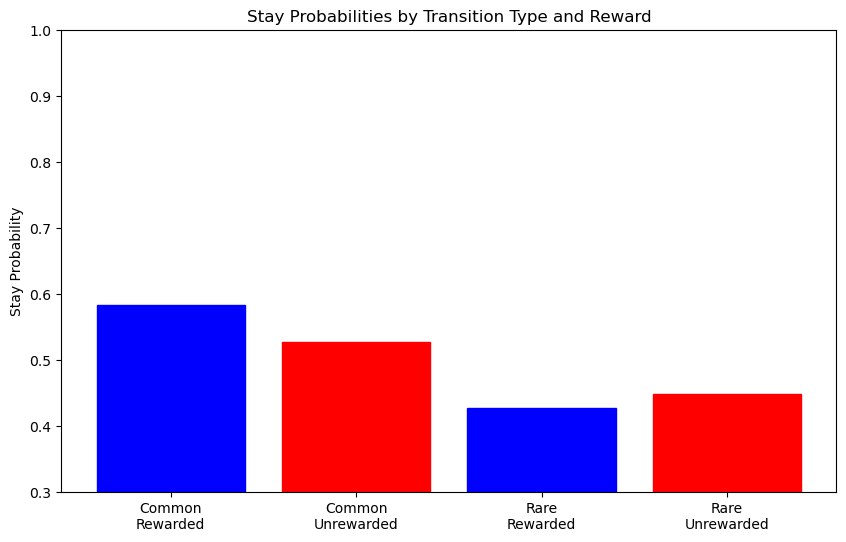

In [16]:
# Run experiment and plot results
# stay_probs = run_experiment(n_trials=1000, n_episodes=200)
stay_probs = run_experiment(n_trials=1000, n_episodes=200, use_imp=True)
plot_stay_probabilities(stay_probs)

### Without importance sampling

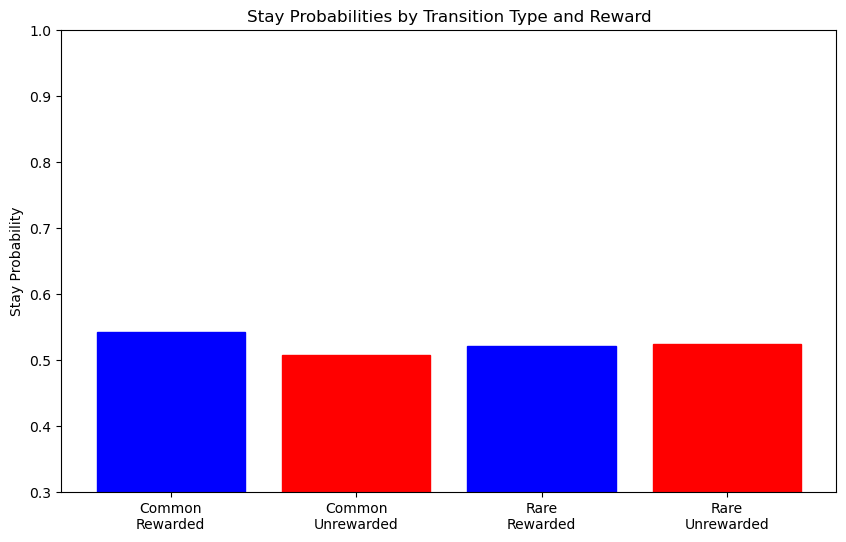

In [17]:
stay_probs = run_experiment(n_trials=1000, n_episodes=200, use_imp=False)
plot_stay_probabilities(stay_probs)